In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *
from ECD_control.ECD_tools.ECD_tools import *
import qutip as qt

In [3]:
#the parameters in our circuit. Can be user defined, or loaded from the result of an ECD optimization.
fname = 'fock_2.npz'
betas = np.load(fname)['betas']
phis = np.load(fname)['phis']
thetas = np.load(fname)['thetas']

#betas = np.array([2*np.sqrt(2.0), -2*np.sqrt(2.0),0.0])
#phis = np.array([0.0, 0.0,0.0])
#thetas = np.array([0.0,0.0])
#thetas = np.array([np.pi/2.0,0.0,np.pi/2.0])
#betas = np.array([2*np.sqrt(2.0),0])
#phis = np.array([0.0,0])
#thetas = np.array([np.pi/2.0,np.pi/2.0])
print('betas:' + str(betas))
print('phis:' + str(phis))
print('thetas:' + str(thetas))

betas:[ 1.4546283 +2.1571472j   0.7158418 +0.43076843j  1.948099  -1.2958955j
  0.08880814-0.5655835j  -0.29272085-0.9692059j  -0.00365159+0.00379038j]
phis:[ 0.         1.6041893 -1.5836263  1.6055623  1.5414847 -3.1094034]
thetas:[ 1.567499  -0.8095143 -1.0500791  1.0925623 -1.1011343 -1.5761303]


the circuit:
betas: [ 1.4546283 +2.1571472j   0.7158418 +0.43076843j  1.948099  -1.2958955j
  0.08880814-0.5655835j  -0.29272085-0.9692059j  -0.00365159+0.00379038j]
phis deg: [   0.         91.91327   -90.7351     91.99194    88.320564 -178.15569 ]
thetas deg: [ 89.81108  -46.381752 -60.1651    62.59921  -63.090347 -90.30561 ]
unitary fid: 0.99361


Text(0.5, 1.0, 'unitary sim')

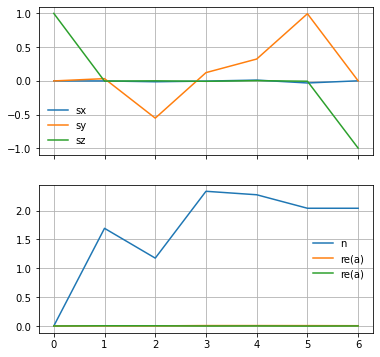

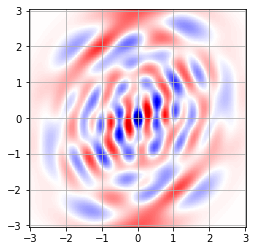

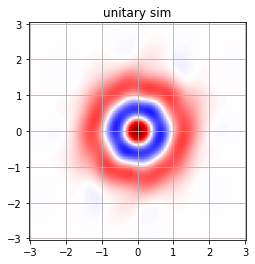

In [4]:
#Now, the unitary simulation
print('the circuit:')
print('betas: ' + str(betas))
print('phis deg: ' + str(180*phis/np.pi))
print('thetas deg: ' + str(180*thetas/np.pi))
N = 30
fock = 2
psi0 = qt.tensor(qt.basis(2,0),qt.basis(N,0))
psit = qt.tensor(qt.basis(2,1),qt.basis(N,fock))
psis = unitary_circuit_sim(psi0, betas, phis, thetas, N)
psif = psis[-1]
plot_expect(psis)
g = qt.tensor(qt.basis(2,0), qt.identity(N))
e = qt.tensor(qt.basis(2,1), qt.identity(N))
psi_g = (g.dag()*psif).unit()
psi_e = (e.dag()*psif).unit()
xvec = np.linspace(-3,3,81)
plot_wigner(psi_g, xvec)
plot_wigner(psi_e, xvec, invert=False)
fid = qt.fidelity(psif, psit)**2
print('unitary fid: %.5f' % fid)
plt.title('unitary sim')

In [10]:
#Our cavity and qubit. When using pulse construction on the FPGA, these objects can be loaded, and 
#the pre-calibrated values can be used. Here, we are making a "FakeCavity" and a "FakeQubit" in order
#to demonstrate the pulse construction when not connected to the FPGA_lib.

#The following parameters are assumed to be defined under your cavity and qubit entity object in FPGA lib.
storage_params = {'chi_kHz': -30, 'chi_prime_Hz': -1.0, 'Ks_Hz': 0, 'epsilon_m_MHz': 0, 'unit_amp': 0.01, 'sigma': 11, 'chop': 4}
qubit_params = {'unit_amp': 0.1, 'sigma': 6, 'chop': 4, 'detune':0}

#calculating epsilon m
wave = storage_params['unit_amp']*gaussian_wave(storage_params['sigma'], storage_params['chop'])
epsilon_m = 1/np.trapz(wave)
epsilon_m_MHz = 1e3*epsilon_m/2/np.pi
print('epsilon_m_MHz: %.6f' % epsilon_m_MHz)
storage_params['epsilon_m_MHz'] = epsilon_m_MHz

pi = rotate(np.pi, phi=0, sigma=qubit_params['sigma'], chop=qubit_params['chop'], dt=1)
Omega_m = np.real(np.max(pi))/qubit_params['unit_amp']

#creating the "Fake storage" and "Fake qubit"
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The alpha used during the ECD gates.
alpha_CD = 40.0
#Buffer time between R and ECD pulses.
buffer_time = 0

epsilon_m_MHz: 691.654892


In [11]:
#generating the conditional displacement circuit with all corrections.
cd_circuit_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,  buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=False, final_disp=True, pad=False, output=True,
                     qubit_phase_correction=True)
cavity_dac_pulse, qubit_dac_pulse, = cd_circuit_dict['cavity_dac_pulse'], cd_circuit_dict['qubit_dac_pulse']
print(cd_circuit_dict['alphas'])

0
  mid_disp: 0.0112 final_disp: 0.0186 first_radius: 39.9977 second_radius: 39.9880
  mid_disp: 0.0118 final_disp: 0.0195 first_radius: 41.9975 second_radius: 41.9874
  mid_disp: 4.0107 final_disp: 3.9799 first_radius: 39.9977 second_radius: 41.9877
  mid_disp: 0.0112 final_disp: 3.9799 first_radius: 39.9977 second_radius: 41.9877
  mid_disp: 0.0112 final_disp: 4.0165 first_radius: 39.9977 second_radius: 39.9880
  mid_disp: 4.0880 final_disp: 4.1172 first_radius: 40.9976 second_radius: 39.9629
  mid_disp: 2.0258 final_disp: 2.0554 first_radius: 40.7476 second_radius: 40.4832
  mid_disp: 1.0226 final_disp: 7.2567 first_radius: 41.3726 second_radius: 39.1650
  mid_disp: 0.2408 final_disp: 1.2416 first_radius: 40.3414 second_radius: 41.3086
  mid_disp: 1.9058 final_disp: 0.6127 first_radius: 40.4195 second_radius: 41.1518
  mid_disp: 0.9289 final_disp: 0.0503 first_radius: 40.5015 second_radius: 40.9861
  mid_disp: 0.3514 final_disp: 4.7519 first_radius: 41.4214 second_radius: 42.1657
  

C:\ProgramData\Miniconda3\envs\opt3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



  mid_disp: 0.5718 final_disp: 1.8077 first_radius: 39.2486 second_radius: 40.0400
  mid_disp: 0.2112 final_disp: 0.9328 first_radius: 40.0787 second_radius: 40.4171
  mid_disp: 0.2234 final_disp: 0.0050 first_radius: 41.7415 second_radius: 41.6668
  mid_disp: 0.3288 final_disp: 0.2368 first_radius: 39.3863 second_radius: 39.9735
  mid_disp: 0.6005 final_disp: 0.3723 first_radius: 39.2809 second_radius: 39.5893
  mid_disp: 0.2285 final_disp: 0.2911 first_radius: 39.5865 second_radius: 39.9403
  mid_disp: 0.1304 final_disp: 0.8200 first_radius: 39.4594 second_radius: 39.9269
  mid_disp: 0.0460 final_disp: 0.3869 first_radius: 39.6143 second_radius: 40.0498
  mid_disp: 0.0184 final_disp: 0.4104 first_radius: 39.1892 second_radius: 39.2152
  mid_disp: 0.0323 final_disp: 0.1520 first_radius: 39.8753 second_radius: 40.3829
  mid_disp: 0.4558 final_disp: 0.3625 first_radius: 40.1514 second_radius: 40.2082
  mid_disp: 0.2568 final_disp: 0.2105 first_radius: 39.9602 second_radius: 40.1515
  m

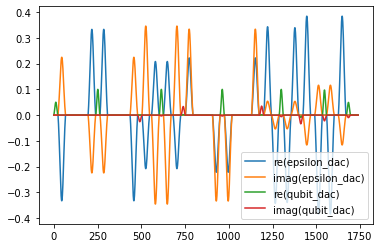

In [12]:
#plotting the pulse
#clip = qubit.pulse.sigma*qubit.pulse.chop
#cavity_dac_pulse = cavity_dac_pulse[clip:-clip]
#qubit_dac_pulse = qubit_dac_pulse[clip:-clip]
plt.plot(np.real(cavity_dac_pulse), label='re(epsilon_dac)')
plt.plot(np.imag(cavity_dac_pulse), label='imag(epsilon_dac)')
plt.plot(np.real(qubit_dac_pulse), label='re(qubit_dac)')
plt.plot(np.imag(qubit_dac_pulse), label='imag(qubit_dac)')
plt.legend()

mid_disp: 80.0910
final_disp: 0.0756
first_radius: 40.1409
second_radius: 0.0328


<Figure size 432x288 with 0 Axes>

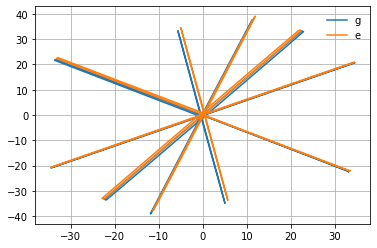

In [13]:
chi = 2*np.pi*1e-6*storage_params['chi_kHz']
chi_prime = 2*np.pi*1e-9*storage_params['chi_prime_Hz']
Ks = 2*np.pi*1e-9*storage_params['Ks_Hz']
delta = -chi/2.0 
plt.figure()

epsilon = epsilon_m*cavity_dac_pulse
flip_idx = int(len(epsilon)/2)
delta = -chi/2.0
alpha_g, alpha_e = get_ge_trajectories(epsilon, delta=delta, chi=chi, flip_idxs=[flip_idx], finite_difference=True)
plot_trajs_complex(alpha_g, alpha_e)
mid_disp = np.abs(alpha_g[flip_idx] + alpha_e[flip_idx])
final_disp = np.abs(alpha_g[-1] + alpha_e[-1])
first_radius = np.abs(
    (alpha_g[int(flip_idx / 2)] + alpha_e[int(flip_idx / 2)]) / 2.0
)
second_radius = np.abs(
    (alpha_g[int(3 * flip_idx / 2)] + alpha_e[int(3 * flip_idx / 2)]) / 2.0
)
print('mid_disp: %.4f' % mid_disp )
print('final_disp: %.4f' % final_disp )
print('first_radius: %.4f' % first_radius )
print('second_radius: %.4f' % second_radius )

In [14]:
N = 30
N2 = 2
rho0 = qt.tensor(qt.basis(N2,0),qt.basis(N,0))
#rho0 = qt.tensor(qt.thermal_dm(N2, 0.05), qt.thermal_dm(N, 0.05))


#qubit_detune = 2*np.pi*1e-9*1e6
qubit_detune = 0
cavity_drive_scale = 1.0
qubit_drive_scale = 1.0
#vlad's anharmonicity
Kq = -2 * np.pi * 1e-3 * 2 * 200
kappa = 0
gamma_down_qubit = 0
#I know this is not quite correct but let's try it
#T2E = 20.0e3
gamma_2 = 0
gamma_phi_qubit = gamma_2 - gamma_down_qubit/2.0
#
#doing master equation simulation
epsilon = cavity_drive_scale*2*np.pi*1e-3*storage_params['epsilon_m_MHz']*cavity_dac_pulse
Omega = qubit_drive_scale*Omega_m*qubit_dac_pulse
me_options = {'Kq':Kq, 'delta':delta, 'chi':chi,
    'chi_prime':chi_prime, 'Ks':Ks, 'kappa':kappa, 'gamma_down_qubit':gamma_down_qubit,
    'gamma_phi_qubit':gamma_phi_qubit, 'output':True, 'qubit_detune':qubit_detune}
result, alpha = simulate_master_equation(epsilon = 1j*epsilon,rho0=rho0,Omega=1j*Omega, **me_options)

Solving for alpha(t)
Constructing Hamiltonian
Running mesolve:
10.0%. Run time:   0.25s. Est. time left: 00:00:00:02
20.0%. Run time:   0.48s. Est. time left: 00:00:00:01
30.0%. Run time:   0.71s. Est. time left: 00:00:00:01
40.0%. Run time:   0.94s. Est. time left: 00:00:00:01
50.0%. Run time:   1.17s. Est. time left: 00:00:00:01
60.0%. Run time:   1.40s. Est. time left: 00:00:00:00
70.0%. Run time:   1.63s. Est. time left: 00:00:00:00
80.0%. Run time:   1.84s. Est. time left: 00:00:00:00
90.0%. Run time:   2.07s. Est. time left: 00:00:00:00
Total run time:   2.26s


In [15]:
rhof = qt.ket2dm(result.states[-1])
#rhof = result.states[-1]
g = qt.tensor(qt.basis(N2,0), qt.identity(N))
e = qt.tensor(qt.basis(N2,1), qt.identity(N))
rhof_g = (g.dag()*rhof*g).unit()
rhof_e = (e.dag()*rhof*e).unit()
#correct final frame
D =  qt.displace(N,alpha[-1])
rhof_g =D*rhof_g*D.dag()
rhof_e =D*rhof_e*D.dag()

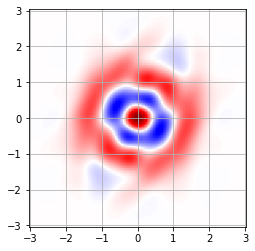

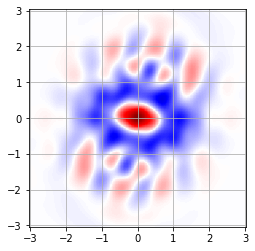

In [16]:
plot_wigner(rhof_g, xvec)
plot_wigner(-1*rhof_e, xvec)

In [17]:
fid_g = qt.fidelity(rhof_g, psi_e)**2
fid_e = qt.fidelity(rhof_e, psi_g)**2
print('fid g: %.6f fid e: %.6f' % (fid_g, fid_e))

fid g: 0.933769 fid e: 0.039743


C:\ProgramData\Miniconda3\envs\opt3\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


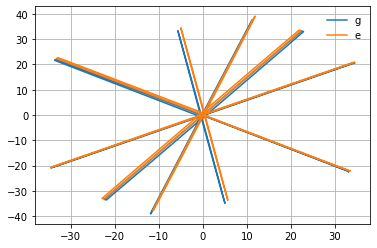

In [18]:
alpha_g, alpha_e = get_ge_trajectories(epsilon, delta=delta, chi=chi, flip_idxs=[int(len(epsilon)/2)])
plot_trajs_complex(alpha_g, alpha_e)